# Entrega 1. Modelización de la energía consumida en el equipo de Auxiliares

##Apartado 1

Cargar los datos “Entregable1.RData”

In [43]:
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
%config IPCompleter.greedy=True #comando para que las graficas nos queden al lado de la celda

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
pip install pyreadr

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from scipy import stats
import pyreadr #este es especifico para poder leer el archivo .RData proporcionado, necesario instalarlo

In [46]:
data = pyreadr.read_r("/content/drive/MyDrive/ML/Entrega_1_Ander/Entregable1.RData")
#extraemos el dataframe principal
df = list(data.values())[0]
#vemos las primeras filas
df.head()

,date_time,ut,eaux_train_ac,event,event_duration,suma_ton_compresores,suma_hvac_ton_compresores,suma_hvac_ton_heater,suma_ton_comp_cab,suma_ton_heater_cab
0,2019-08-31 22:00:25,18.0,0.058971,stop,15.0,4.0,0.0,0.0,0.0,0.0
1,2019-08-31 22:00:40,18.0,0.454582,interstation,98.0,0.0,65.0,0.0,0.0,0.0
2,2019-08-31 22:00:55,6.0,0.036858,stop,13.0,0.0,0.0,0.0,0.0,0.0
3,2019-08-31 22:01:08,6.0,0.550169,interstation,108.0,76.0,0.0,0.0,0.0,0.0
4,2019-08-31 22:02:18,18.0,0.051877,stop,11.0,0.0,11.0,0.0,0.0,0.0


## Apartado 2

Filtrar los datos

In [47]:
#Comenzamos eliminando los eventos con mas de 600 segundos
df=df[df['event_duration']<=600]
df.sort_values(by=['event_duration'],ascending=False).head()
#vemos como el mayor de los tiempos es de 599 segundos

,date_time,ut,eaux_train_ac,event,event_duration,suma_ton_compresores,suma_hvac_ton_compresores,suma_hvac_ton_heater,suma_ton_comp_cab,suma_ton_heater_cab
47853,2019-09-06 05:44:04,32.0,3.034377,interstation,600.0,233.0,0.0,0.0,0.0,0.0
188483,2019-09-20 11:23:00,13.0,4.574768,stop,600.0,67.0,1104.0,0.0,285.0,0.0
236532,2019-09-25 10:43:07,30.0,3.625747,interstation,600.0,295.0,185.0,0.0,0.0,0.0
245664,2019-09-26 06:41:55,16.0,2.803589,stop,600.0,218.0,120.0,0.0,0.0,0.0
43770,2019-09-05 15:32:47,32.0,3.719520,interstation,600.0,222.0,365.0,0.0,0.0,0.0


In [48]:
#eliminamos ahora los eventos de mantenimiento, para ellos primero vemos la nomenclatura
pd.unique(df['event'])
#con lo cual, las celdas que tenemos que eliminar son aquellas en las que event tenga "MAINTENANCE"

array(['stop', 'interstation', 'MAINTENANCE'], dtype=object)

In [49]:
df=df[df['event']!='MAINTENANCE']
pd.unique(df['event']) #vemos como ya hemos eliminado las filas de mantenimiento


array(['stop', 'interstation'], dtype=object)

##Apartado 3

Comparativa de consumos

Primero vamos a empezar comparando el consumo (kWh) entre el evento intersation y stop

In [50]:
#Para ello, lo esencial es dividir todas nuestras muestras entre los dos grupos
df_inter=df[df['event']=='interstation']
df_stop=df[df['event']=='stop']

In [51]:
#Hacemos un test de sahpiro para comprobar normalidad y saber si hacer test parametrico o no
shapiro_inter = stats.shapiro(df_inter['eaux_train_ac'])
shapiro_stop = stats.shapiro(df_stop['eaux_train_ac'])
print(shapiro_inter.pvalue, shapiro_stop.pvalue)

3.353369068411305e-141 2.555285645887838e-173


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 138628.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 136939.
  res = hypotest_fun_out(*samples, **kwds)


Nos da que no siguen una normal, pero tambien nos da un aviso de que para un numero elevado de muestras puede que el test no sea exacto. Con lo cual, haremos tanto el test paramétrico (ttest) como el no paramétrico (Wilcoxon)

In [52]:
#Ejecutamos un t.test entre las dos muestras
t_stat, p_val =stats.ttest_ind(df_inter['eaux_train_ac'], df_stop['eaux_train_ac'], equal_var=False)
print("t_statistic: ",t_stat,"p.value: ",p_val)

t_statistic:  334.421091944355 p.value:  0.0


nos sale una diferencia altamente significativa

In [53]:
#Pasamos a ejecutar un wilcoxon test
u_stat, p_val_u = stats.mannwhitneyu(df_inter['eaux_train_ac'], df_stop['eaux_train_ac'], alternative='two-sided')
print("u_statistic: ",u_stat,"p.value: ",p_val_u)

u_statistic:  17286347210.5 p.value:  0.0


nos sale una diferencia significativa también

/tmp/ipython-input-4268289170.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='event', ylabel='eaux_train_ac'>

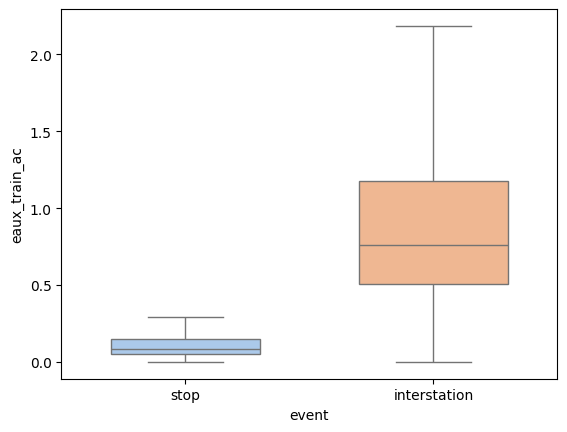

In [54]:
#podemos representar los consumos de ambos casos en un boxplot, para corroborar nuestra hipotesis
subset = df[df['event'].isin(['interstation', 'stop'])]
sns.boxplot(
    data=subset,
    x='event',
    y='eaux_train_ac',
    palette='pastel',
    showfliers=False,
    width=0.6
)


En el boxplot se ve como claramente el consumo en los casos de interstation son mayores

Sin embargo, como el numero de muestras es muy grande. Que haya evidencia en el ttest y en el wilcoxon test es mucho mas sencillo. Por ello, podemos hacer un curva ROC y evaluar la diferencia tambien bajo este criterio

In [55]:
from sklearn.metrics import roc_curve, auc

#para hacer la curva ROC, tenemos que crear una variable binaria para distinguir entre categorías (stop e interstation)
df['event_bin'] = (df['event'] == 'interstation').astype(int)

#ahora asignamos las columnas a dos variables separadas para luego meterlas en la funcion ROC
y_true = df['event_bin']
y_score = df['eaux_train_ac']

fpr, tpr, thresholds = roc_curve(y_true, y_score) #false positive rate, true positive rate y thresholds
roc_auc = auc(fpr, tpr) #area bajo la curva
print(roc_auc)

0.9105947082143183


Vemos como el area bajo la curva es 0.87, lo cual es buena señal porque indica que la relacion no es aleatoria sino que hay diferencias. Sin embargo, vamos a representar la curva ROC para ver su forma

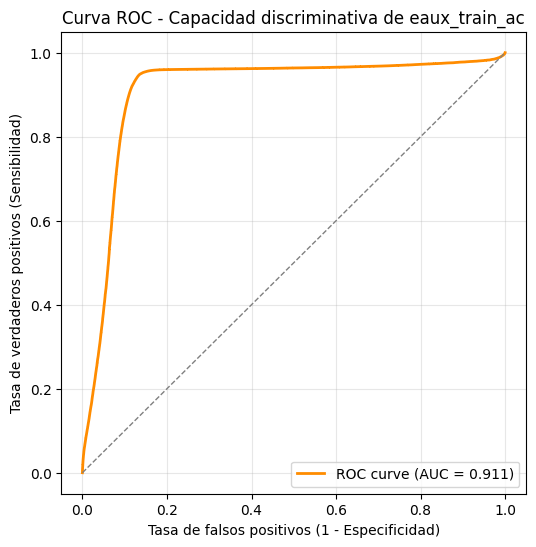

In [56]:
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
plt.ylabel('Tasa de verdaderos positivos (Sensibilidad)')
plt.title('Curva ROC - Capacidad discriminativa de eaux_train_ac')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Vemos como la curva ROC tiene una muy buena forma. Por lo tanto, despues de todo esto, podemo afirmar que hay diferencia en el consumo entre los eventos de "interstations" y "stop"

Ahora pasamos a comparar, no el consumo, sino la energía entre los eventos de "interstations" y "stop". Vamos a seguir el mismo procedimiento anterior, pero antes que nada tendremos que crear una columna que sea el consumo de cada uno de los eventos

In [57]:
df['con_aux_train_ac'] = df['eaux_train_ac'] / (df['event_duration'] / 3600)
df['con_aux_train_ac'].head()

,con_aux_train_ac
0,14.153107
1,16.698914
2,10.206842
3,18.338954
4,16.977956


In [58]:
df.head()

,date_time,ut,eaux_train_ac,event,event_duration,suma_ton_compresores,suma_hvac_ton_compresores,suma_hvac_ton_heater,suma_ton_comp_cab,suma_ton_heater_cab,event_bin,con_aux_train_ac
0,2019-08-31 22:00:25,18.0,0.058971,stop,15.0,4.0,0.0,0.0,0.0,0.0,0,14.153107
1,2019-08-31 22:00:40,18.0,0.454582,interstation,98.0,0.0,65.0,0.0,0.0,0.0,1,16.698914
2,2019-08-31 22:00:55,6.0,0.036858,stop,13.0,0.0,0.0,0.0,0.0,0.0,0,10.206842
3,2019-08-31 22:01:08,6.0,0.550169,interstation,108.0,76.0,0.0,0.0,0.0,0.0,1,18.338954
4,2019-08-31 22:02:18,18.0,0.051877,stop,11.0,0.0,11.0,0.0,0.0,0.0,0,16.977956


In [59]:
#Para ello, lo esencial es dividir todas nuestras muestras entre los dos grupos
df_inter=df[df['event']=='interstation']
df_stop=df[df['event']=='stop']

Pasamos a realizar tanto el ttest como el test de Wilcoxon

In [60]:
#ttest
t_stat_1, p_val_1 =stats.ttest_ind(df_inter['con_aux_train_ac'], df_stop['con_aux_train_ac'], equal_var=False)
print("t_statistic: ",t_stat_1,"p.value: ",p_val_1)

t_statistic:  24.801944833528843 p.value:  1.210754067351315e-135


In [61]:
#wilcoxon
u_stat_1, p_val_u_1 = stats.mannwhitneyu(df_inter['con_aux_train_ac'], df_stop['con_aux_train_ac'], alternative='two-sided')
print("u_statistic: ",u_stat_1,"p.value: ",p_val_u_1)

u_statistic:  10245177503.5 p.value:  4.1529179183433145e-285


En ambos casos nos sale significativo, pero al igual que en el caso anterior. El numero de muestras es muy grande y por lo tanto la facilidad para encontrar evidencia con estos test es mucho mas sencillo

Realizamos ahora la curva ROC

In [62]:
y_true = df['event_bin']
y_score_1 = df['con_aux_train_ac']

fpr_1, tpr_1, thresholds_1 = roc_curve(y_true, y_score_1) #false positive rate, true positive rate y thresholds
roc_auc_1 = auc(fpr_1, tpr_1) #area bajo la curva
print(roc_auc_1)

0.539686279917875


Vemos como ahora el area bajo la curva prácticamente representa un evento aleatorio (area=0.5). Representamos la curva para una mejor comprensión

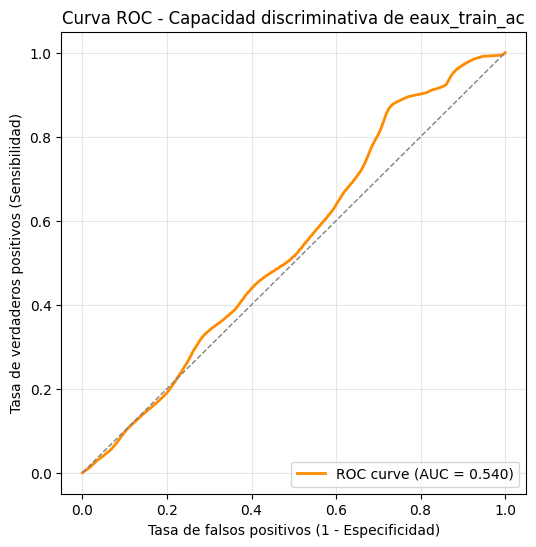

In [63]:
plt.figure(figsize=(6,6))
plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_1:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('Tasa de falsos positivos (1 - Especificidad)')
plt.ylabel('Tasa de verdaderos positivos (Sensibilidad)')
plt.title('Curva ROC - Capacidad discriminativa de eaux_train_ac')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Confirmamos lo anterior. En este caso la curva ROC nos dice que no hay relacion entre los eventos de "stop" e "interstations" en lo que a potencia se refiere. Este ejemplo ha sido muy bueno para demostrar que, a pesar que los Ttest y Wilcoxon test nos daban significativos, la curva ROC ha demostrado que no hay relación. Esto ha ocurrido debido a lo explicado anteriormente, al haber muchas muestras es relativamente sencillo encontrar un p.value<0.05 debido a una pequeña diferencia

## Apartado 4

Generar un modelo de regresión lineal del consumo (eaux_train_ac) con la primera quincena de datos. Para ello, modelizar el consumo de auxiliares con los datos filtrados (del punto 3)

Aqui, el primero modelo que se va a abordar es un modelo reducido en el que solo se han tenido en cuenta las variables numéricas ignorando la variable categórica de si está en marcha o no

In [64]:
#filtramos para la primera quincena
df['date_time'] = pd.to_datetime(df['date_time'])
first_half = df[df['date_time'].dt.day <= 15] #primera quincena
second_half = df[df['date_time'].dt.day > 15] #segunda quincena

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

linear_model=LinearRegression() #definimos el modelo de regresion lineal
#definimos las variables que vamos a meter en el modelo para intentar explicar el consumo
features = [
    'suma_ton_compresores',
    'suma_hvac_ton_compresores',
    'suma_hvac_ton_heater',
    'suma_ton_comp_cab',
    'suma_ton_heater_cab'
]
#no incluimos la columna de event_duration ni ut puesto que asi lo especifica el enunciado
#tampoco incluimos la columna de event puesto que es categórica y describe mas un escenario que una causa del consumo

x_train = first_half[features]
y_train = first_half['eaux_train_ac']

Ahora entrenamos el modelo con los datos de la primera quincena

In [66]:
linear_model.fit(x_train,y_train)

coef_df = pd.DataFrame({
    'Variable': features,
    'Coeficiente': linear_model.coef_
})
print("\n=== Coeficientes del modelo lineal ===")
print(coef_df)
print(f"Intercepto: {linear_model.intercept_:.4f}")


=== Coeficientes del modelo lineal ===
                    Variable  Coeficiente
0       suma_ton_compresores     0.007071
1  suma_hvac_ton_compresores     0.003115
2       suma_hvac_ton_heater     0.004330
3          suma_ton_comp_cab     0.001054
4        suma_ton_heater_cab     0.001065
Intercepto: 0.1244


In [67]:
linear_model

LinearRegression()

Ahora paso a crear un modelo estratificado en funcion del "event" ya que, como hemos demostrado anteriormente, hay diferencias en el consumo cuando cambia el evento

In [68]:
df['event_interstation'] = df['event'].map({'stop': 0, 'interstation': 1})

In [69]:
#Volvemos a filtrar la quincena para que se actualice y meta el valor de event_interstation
df['date_time'] = pd.to_datetime(df['date_time'])
first_half = df[df['date_time'].dt.day <= 15] #primera quincena
second_half = df[df['date_time'].dt.day > 15] #segunda quincena

In [70]:
linear_model_estrato=LinearRegression() #definimos el modelo de regresion lineal
#definimos las variables que vamos a meter en el modelo para intentar explicar el consumo
features_1 = [
    'suma_ton_compresores',
    'suma_hvac_ton_compresores',
    'suma_hvac_ton_heater',
    'suma_ton_comp_cab',
    'suma_ton_heater_cab',
    'event_interstation'
]

x_train_estrato = first_half[features_1]
y_train_estrato = first_half['eaux_train_ac']

In [71]:
linear_model_estrato.fit(x_train_estrato,y_train_estrato)

coef_df_estrato = pd.DataFrame({
    'Variable': features_1,
    'Coeficiente': linear_model_estrato.coef_
})
print("\n=== Coeficientes del modelo estratificado ===")
print(coef_df_estrato)
print(f"Intercepto: {linear_model_estrato.intercept_:.4f}")


=== Coeficientes del modelo estratificado ===
                    Variable  Coeficiente
0       suma_ton_compresores     0.006479
1  suma_hvac_ton_compresores     0.002963
2       suma_hvac_ton_heater     0.004196
3          suma_ton_comp_cab     0.000995
4        suma_ton_heater_cab     0.001004
5         event_interstation     0.200808
Intercepto: 0.0549


Aqui vemos como ahora tenemos un coeficiente más que el anterior modelo. Es el que pertenece al evento.

Una tercera opcion sería crear un modelo lineal simple por separado para cada uno de los eventos. Empezando por dividir los datos

In [72]:
#creamos los dos modelos por separado
linear_model_stop=LinearRegression()
linear_model_interstation=LinearRegression()

#definimos datos de entrenamiento y test
x_train_stop = first_half[first_half['event']=='stop'][features]
y_train_stop = first_half[first_half['event']=='stop']['eaux_train_ac']

x_train_interstation = first_half[first_half['event']=='interstation'][features]
y_train_interstation = first_half[first_half['event']=='interstation']['eaux_train_ac']


In [73]:
linear_model_stop.fit(x_train_stop,y_train_stop)

coef_df_stop = pd.DataFrame({
    'Variable': features,
    'Coeficiente': linear_model_stop.coef_
})
print("\n=== Coeficientes del modelo lineal stop ===")
print(coef_df_stop)
print(f"Intercepto: {linear_model_stop.intercept_:.4f}")

linear_model_interstation.fit(x_train_interstation,y_train_interstation)

coef_df_interstation = pd.DataFrame({
    'Variable': features,
    'Coeficiente': linear_model_interstation.coef_
})
print("\n=== Coeficientes del modelo lineal interstation===")
print(coef_df_interstation)
print(f"Intercepto: {linear_model_interstation.intercept_:.4f}")



=== Coeficientes del modelo lineal stop ===
                    Variable  Coeficiente
0       suma_ton_compresores     0.006920
1  suma_hvac_ton_compresores     0.003524
2       suma_hvac_ton_heater     0.004310
3          suma_ton_comp_cab     0.001423
4        suma_ton_heater_cab     0.000513
Intercepto: 0.0390

=== Coeficientes del modelo lineal interstation===
                    Variable  Coeficiente
0       suma_ton_compresores     0.006431
1  suma_hvac_ton_compresores     0.002891
2       suma_hvac_ton_heater     0.004114
3          suma_ton_comp_cab     0.000908
4        suma_ton_heater_cab     0.001042
Intercepto: 0.2673


##Apartado 5

Revisión del modelo de regresión generado

¿El modelo generado es explicativo? Justifica la respuesta


El modelo sí que tiene un carácter explicativo, ya que trata de entender como contribuyen las diferentes features al consumo total. Las diferentes features representan el tiempo de encendido de los diferentes equipos, por lo que cada coeficiente estima cuanto aumenta el consumo electrico cuando el equipo opera durante más tiempo. Además tenemos una R2 significativamente alto

In [74]:
from sklearn.metrics import r2_score

# R² del modelo lineal con evento (train y test)
r2_train = linear_model_estrato.score(x_train_estrato, y_train_estrato)
print(f"Lineal (con evento) → R² train: {r2_train:.4f}")


Lineal (con evento) → R² train: 0.9020


¿Tiene sentido trabajar con un modelo reducido o por estratos? Justifica la respuesta

Desde mi punto de vista, tendría más sentido trabajar con un modelo estratificado. El motivo de ello reside en que en los diferentes tipos de evento (stop, interstation) hemos visto en el apartado 3 como el consumo (eaux_train_ac) es diferente. Por lo tanto, los coeficientes para cada una de las features (datos de consumo) se podrían ajustar en funcion del evento. Si hubiera la posibilidad de ir cambiando de modelo de prediccion en función del evento (que lo desconozco) utilizaría un modelo lineal para cada momento. Pero si por el contrario no es posible cambiar el modelo entre evento utilizaría el estratificado conjunto que he creado teniendo en cuenta directamente el evento. En mi caso, voy a continuar con el modelo estratificado conjunto que tiene en cuenta el modelo por simplicidad para luego no tener que separar los datos

Enumerar las variables que son estadísticamente significativas

Para responder a esto vamos a tener que calcular los p.values de cada una de las features

In [75]:
import statsmodels.api as sm #necesitamos importar esta funcion para ejecutar los p.values y verlos mejor como si fuera R

x_train_sm = sm.add_constant(x_train_estrato) #añadimos una constante igual a 1 a los datos de train para que luego el modelo tenga en cuenta el termino intercept
model_sm = sm.OLS(y_train_estrato, x_train_sm).fit() #creamos el modelo y lo entrenamos
print(model_sm.summary()) #vemos los resultados

                            OLS Regression Results                            
Dep. Variable:          eaux_train_ac   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                 2.045e+05
Date:                Mon, 27 Oct 2025   Prob (F-statistic):               0.00
Time:                        19:31:22   Log-Likelihood:                 7975.1
No. Observations:              133306   AIC:                        -1.594e+04
Df Residuals:                  133299   BIC:                        -1.587e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

Los resultados de los coeficientes son, lógicamente, iguales a cuando aplicamos LinearRegression(). Lo que ocurre es que aqui podemos ver más datos.

Todos los coeficientes del modelo tienen p.values prácticamente nulos lo que indica que sson estadisticamente significativos.
Esto se debe, en parte, al gran tamaño muestral, comentado ya anteriormente

Por tanto, aunque la significancia estadística es total, debemos tener en cuenta también la magnitud de cada uno de los coeficientes y no solo el p.value.

Explicar el significado de cada coeficiente de regresión

In [76]:
#imprimimos los coeficientes de regresion
print("\n=== Coeficientes del modelo lineal ===")
print(coef_df_estrato)
print(f"Intercepto: {linear_model_estrato.intercept_:.4f}")


=== Coeficientes del modelo lineal ===
                    Variable  Coeficiente
0       suma_ton_compresores     0.006479
1  suma_hvac_ton_compresores     0.002963
2       suma_hvac_ton_heater     0.004196
3          suma_ton_comp_cab     0.000995
4        suma_ton_heater_cab     0.001004
5         event_interstation     0.200808
Intercepto: 0.0549


Cada uno de los coeficientes de regresión indica el cambio esperado en la variable que queremos predecir por cada unidad de la variable independiente. Es decir, la influencia que tiene cada una de las variables independientes en la variable dependiente, traducido a nuestro sistema representaría que sistemas consumen más. Por otro lado, el intercept representa el punto de corte con la variable independiente cuando todos los valores son 0, sería como el consumo base del sistema cuando todos los aparatos estan apagados. Por otro lado, todos los coeficientes son positivos, con lo cual, tiene sentido ya que cuanto mayor sea el tiempo de encendido mayor será el consumo. Por último, tal y como se ha mencionado anteriormente el coeficiente que representa el evento es el que mas influencia y peso tiene dentro de los coeficientes. En el caso del coeficiente del event_interstation que es un dummie, representa el cambio en el consumo que supone pasar de stop a interstation.

Estimar el consumo en KW para cada coeficiente regresión

Sería hacer la conversión que hemos hecho anteriormente para crear la columna de kW. No estoy seguro si al coeficiente de las variable categórica habría que aplicarle tambien esta transromacion puesto que no multiplica a valores de segundos

In [77]:
coef_df['Coef_kW'] = coef_df['Coeficiente'] * 3600
coef_df

,Variable,Coeficiente,Coef_kW
0,suma_ton_compresores,0.007071,25.455970
1,suma_hvac_ton_compresores,0.003115,11.213152
2,suma_hvac_ton_heater,0.004330,15.588305
3,suma_ton_comp_cab,0.001054,3.793627
4,suma_ton_heater_cab,0.001065,3.834816


Dibujar la distribución de los residuos. ¿Se observa alguna anomalía? En el caso de que exista, ¿se puede
explicar? Justifica tu respuesta.

Podemos ver ahora los errores que tiene el modelo

In [78]:
y_pred_train = linear_model_estrato.predict(x_train_estrato) #esta es la validacion con los propios datos de entrenamiento

mse_train = mean_squared_error(y_train_estrato, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train_estrato, y_pred_train)

print("\n=== Resultados del modelo lineal ===")
print(f"RMSE (Train): {rmse_train:.3f}")
print(f"R² (Train)  : {r2_train:.3f}")



=== Resultados del modelo lineal ===
RMSE (Train): 0.228
R² (Train)  : 0.902


Una vez que hemos calculado los errores, podemos ver los residuos

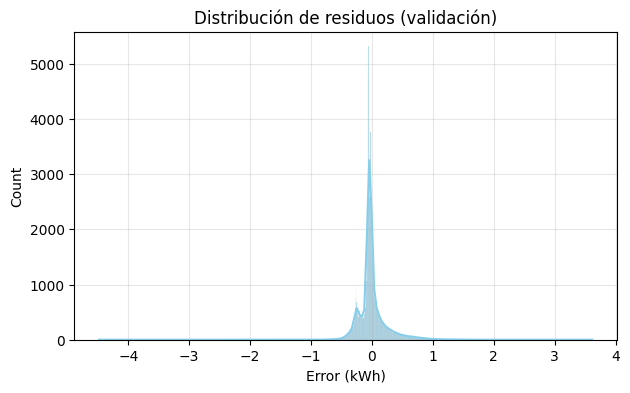

In [79]:
residuos = y_train_estrato - y_pred_train

plt.figure(figsize=(7,4))
sns.histplot(residuos, kde=True, color='skyblue')
plt.title("Distribución de residuos (validación)")
plt.xlabel("Error (kWh)")
plt.grid(alpha=0.3)
plt.show()

Claramente la distribución tiene una anomalía. Debería de ser una distribución normal pero tiene un pico en el punto de error alrededor de -0.2 y 0. Podría relacionarse con el hecho de que haya algún valor atipico que dispare dicho error y por eso se representa en el histograma mediante un pico. También una de las posibilidades es que una de las variables que hemos eliminado sea que la responsable de explicar parte del consumo.

Vamos a intentar limpiar los datos e incluir la unidad de tren como variable categórica

Límites IQR residuos: [-0.551, 0.497]
Filas train: 133306 -> tras limpieza: 127668

=== MODELO LIMPIO (EVENTO + UT, SIN OUTLIERS) ===
RMSE (train): 0.1539
R² (train)  : 0.9441


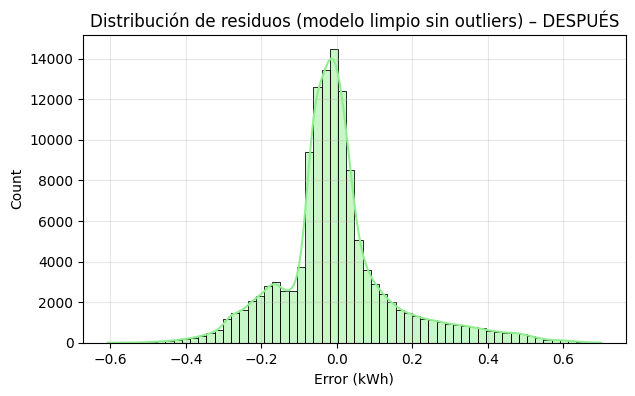

In [80]:
# --- 1. One-hot encoding de 'ut' (la unidad del tren) ---
d_train = pd.get_dummies(first_half['ut'].astype(str), prefix='ut', drop_first=True)

# --- 2. Extendemos las features ---
features_ut = features_1 + list(d_train.columns)

x_train_ut = pd.concat([x_train_estrato.reset_index(drop=True),
                        d_train.reset_index(drop=True)], axis=1)

# --- 3. Entrenamos el modelo lineal con evento + unidad ---
linear_model_ut = LinearRegression()
linear_model_ut.fit(x_train_ut, y_train_estrato)

# --- 4. Predicciones (train) ---
y_pred_train_ut = linear_model_ut.predict(x_train_ut)

# ==========================
# LIMPIEZA DE OUTLIERS (IQR)
# ==========================
# Alineamos índice y trabajamos con arrays para evitar problemas de indexado
y_train_vec = y_train_estrato.reset_index(drop=True)
res_vec = (y_train_vec.values - y_pred_train_ut)  # array

q1, q3 = np.percentile(res_vec, [25, 75])
iqr = q3 - q1
lim_inf = q1 - 3*iqr
lim_sup = q3 + 3*iqr
print(f"Límites IQR residuos: [{lim_inf:.3f}, {lim_sup:.3f}]")

mask_clean = (res_vec >= lim_inf) & (res_vec <= lim_sup)

# Submuestra limpia (nuevos objetos, no toco tus tablas originales)
x_train_ut_clean = x_train_ut.iloc[mask_clean].copy()
y_train_ut_clean = y_train_vec.iloc[mask_clean].copy()

print(f"Filas train: {len(y_train_vec)} -> tras limpieza: {len(y_train_ut_clean)}")

# --- Reentrenamos con datos limpios ---
linear_model_ut_clean = LinearRegression()
linear_model_ut_clean.fit(x_train_ut_clean, y_train_ut_clean)

# --- Predicciones y métricas (modelo limpio) ---
y_pred_train_ut_clean = linear_model_ut_clean.predict(x_train_ut_clean)
rmse_train_clean = np.sqrt(mean_squared_error(y_train_ut_clean, y_pred_train_ut_clean))
r2_train_clean   = r2_score(y_train_ut_clean, y_pred_train_ut_clean)

print("\n=== MODELO LIMPIO (EVENTO + UT, SIN OUTLIERS) ===")
print(f"RMSE (train): {rmse_train_clean:.4f}")
print(f"R² (train)  : {r2_train_clean:.4f}")

# --- Distribución de residuos ---
residuos_clean = y_train_ut_clean - y_pred_train_ut_clean
plt.figure(figsize=(7,4))
sns.histplot(residuos_clean, kde=True, color='lightgreen', bins=60)
plt.title("Distribución de residuos (modelo limpio sin outliers) – DESPUÉS")
plt.xlabel("Error (kWh)")
plt.grid(alpha=0.3)
plt.show()



Vemos como las metricas de R2 y RMSE han mejorado notablemente, son valores realmente buenos. También se aprecia como la distribucion de los residuos se acerca bastante a una normal. Por lo tanto, puede que los valores atípicos y la variable ut (numero de tren) fueran los responsables de las anomalías en el caso anterior.

##Apartado 6

Validar el modelo de regresión generado en el punto 4) con los datos de la segunda quincena de septiembre

In [81]:
#creamos el set de test
x_test = second_half[features_1]
y_test = second_half['eaux_train_ac']

In [82]:
x_test

,suma_ton_compresores,suma_hvac_ton_compresores,suma_hvac_ton_heater,suma_ton_comp_cab,suma_ton_heater_cab,event_interstation
0,4.0,0.0,0.0,0.0,0.0,0
1,0.0,65.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0
3,76.0,0.0,0.0,0.0,0.0,1
4,0.0,11.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...
290642,0.0,0.0,0.0,0.0,0.0,1
290644,0.0,0.0,0.0,0.0,0.0,0
290645,0.0,0.0,0.0,0.0,0.0,0
290646,45.0,0.0,0.0,0.0,0.0,1


In [83]:
y_pred_test = linear_model_estrato.predict(x_test) #calculamos los valores predichos de y

mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n=== Resultados test del modelo lineal ===")
print(f"RMSE (Test): {rmse_test:.3f}")
print(f"R² (Test)  : {r2_test:.3f}")


=== Resultados test del modelo lineal ===
RMSE (Test): 0.225
R² (Test)  : 0.909


El modelo generaliza bien, ya que el error (RMSE) en los datos de test y validación son muy parecidos (0.228 y 0.225 respectivamente). Además el R2 es incluso superior, por tanto, explicamos una mayor variabilidad del consumo en los datos de test que en los de train

##Apartado 7

Generar un modelo predictivo de ML más complejo con el subset de entrenamiento y validarlo en el subset de
validación definidos anteriormente

El Modelo de ML alternativo elegido ha sido uno de random Forest ya que fue uno de enseñados en el ejemplo en clase

In [84]:
#creamos el modelo
model_rf = RandomForestRegressor(
    n_estimators=200,       #número de árboles
    max_depth=None,         #sin límite de profundidad
    random_state=42,        #para que luego podamos reproducir los resultados
    n_jobs=-1               #con este argumento usa todos los núcleos del procesador
)
model_rf.fit(x_train_estrato,y_train_estrato) #lo entrenamos con la primera quincena

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

Una vez que tenemos el modelo creado y entrenado. Validamos los resultados con los datos de train (primera quincena) y con los datos de test (segunda quincena)

In [85]:
y_pred_rf_train = model_rf.predict(x_train_estrato)
y_pred_rf_test = model_rf.predict(x_test)

rmse_rf_train = np.sqrt(mean_squared_error(y_train_estrato, y_pred_rf_train))
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf_test))

print("\n=== Resultados test del modelo Random Forest ===")
print(f"RMSE (Train): {rmse_rf_train:.3f}")
print(f"RMSE (Train)  : {rmse_rf_test:.3f}")


=== Resultados test del modelo Random Forest ===
RMSE (Train): 0.143
RMSE (Train)  : 0.200


Habiendo calculado ya los RMSE del Random Forest, podemos comparar los valores de este modelo con el lineal

In [86]:
print("\n--- COMPARATIVA MODELOS RMSE ---")
print(f"Lineal -> Train: {rmse_train:.3f}, Val: {rmse_test:.3f}")
print(f"RF     -> Train: {rmse_rf_train:.3f}, Val: {rmse_rf_test:.3f}")



--- COMPARATIVA MODELOS RMSE ---
Lineal -> Train: 0.228, Val: 0.225
RF     -> Train: 0.143, Val: 0.200


In [87]:
from sklearn.metrics import r2_score

# R² en entrenamiento (primera quincena)
r2_train_rf = model_rf.score(x_train_estrato, y_train_estrato)

# R² en validación (segunda quincena)
r2_test_rf = model_rf.score(x_test, y_test)

print(f"R² del Random Forest - train: {r2_train_rf:.4f}")
print(f"R² del Random Forest - test : {r2_test_rf:.4f}")

R² del Random Forest - train: 0.9612
R² del Random Forest - test : 0.9284


In [88]:
print("\n--- COMPARATIVA MODELOS R2---")
print(f"Lineal -> Train: {r2_train:.3f}, Val: {r2_test:.3f}")
print(f"RF     -> Train: {r2_train_rf:.3f}, Val: {r2_test_rf:.3f}")


--- COMPARATIVA MODELOS R2---
Lineal -> Train: 0.902, Val: 0.909
RF     -> Train: 0.961, Val: 0.928


Se pueden observar varias claves. La primera de todas es que los resultados del Random Forest son mejores que los del modelo lineal ya que mejora la capacidad predicitiva al tener menor RMSE (tanto en el train como en el test) y mayor R2. No obstante, la variabilidad entre los RMSE del Random Forest es mayor. Lo cual significa que el modelo generaliza peor que el modelo lineal, probablemente debido a un execeso de overfitting.

Para la explicabilidad de las variables en el RandomForest, podemos hacer uso de un comando que nos indica ya la importancia de las variables. Esta importancia indica cuales tienen mayor influencia global sobre el resultado, pero sin especificar si esa influencia es positiva o negativa ni su magnitud exacta. Lo que calcula es la importancia por reducción media de la impureza (Mean Decrease in Impurity, MDI). Con lo cual, en el modelo de Random Forest es más predictivo pero menos explicativo que el modelo lineal.

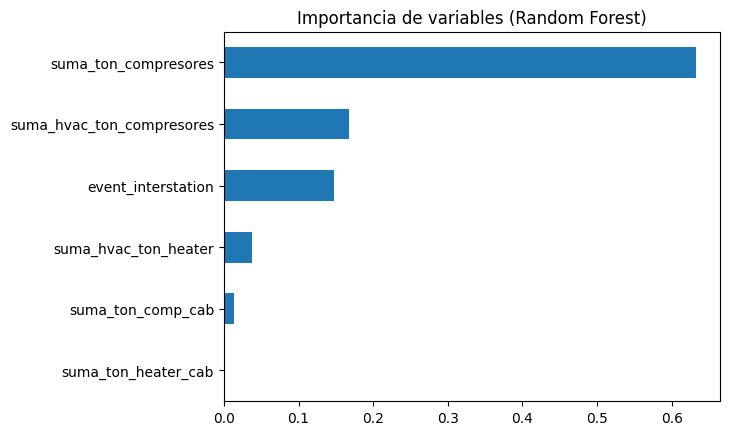

In [89]:
#creamos un dataframe con las impoprtancias de cada variable y las variables
importances = pd.Series(model_rf.feature_importances_, features_1)

#pasamos a representar los valores en un diagrama de barras horizontal
importances.sort_values(ascending=True).plot.barh()
plt.title("Importancia de variables (Random Forest)")
plt.show()

El consumo se explica principalmente por los compresores y calefactores de sala y tren. Seguidos del tipo de evento, es decir, si el tren esta en marcha o parado. Mientras que los equipos de cabina tienen menor impacto, por lo tanto, en el caso de que nuestro modelo de RandomForest tuviera un exceso de overfitting, podríamos emplear estas importancias para hacer "feature selection". Otro aspecto muy interesante que se ve en esta gráfica es que en este modelo de RandomForest el tipo de evento no cobra tanta importancia como parecía que cobraba en el modelo lineal


Finalmente, el modelo que desplegaría sería el de Random Forest debido a que presenta una mayor capacidad de predicción y no tiene un exceso de overfitting(hecho que podría haber ocurrido perfectamente en este tipo de modelos) con el entrenamiento realizado. No obstante, la predictibildad que tiene el modelo lineal es realmente buena ya que el error entre los datos de entrenamiento y test son realmente cercanos

Nota final: por suerte o por desgracia, la primera vez que me puse con el entregable no incluí la variable categórica de event porque no me percate se su posible importancia. Esto provocó que llegara a hacer el random forest solo con las variables numéricas y no tener en cuenta el tipo de evento. Con lo cual, he podido comparar resultados y cuando le metes solo las variables numéricas al RandomForest los resultados son peores de los obtenidos cuando le metes también la variable categorica de evento